In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import random
import torch.optim as optim
import os
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.nn.utils.rnn import pad_sequence
import torch.nn.functional as F
from torch.utils.data import DataLoader


In [2]:
# Load data
df = pd.read_csv('./Datasets/master_csv_0.csv')

# Choose features
imu_features = [
    'accel_x_filtered', 'accel_z_filtered', 'gyro_y_filtered', 'gyro_z_filtered'
]
target_column = 'filtered_emg'

imu_segments = []
emg_segments = []

# Loop over unique segments
for segment_uid in df['Segment UID'].unique():
    segment_df = df[df['Segment UID'] == segment_uid]

    # Extract IMU and EMG data
    imu_data = segment_df[imu_features].values
    emg_data = segment_df[target_column].values

    # Store them as separate entries
    imu_segments.append(imu_data)
    emg_segments.append(emg_data)


In [3]:
class WaveNetBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, dilation):
        super(WaveNetBlock, self).__init__()
        self.causal_conv = nn.Conv1d(
            in_channels,
            out_channels,
            kernel_size=kernel_size,
            padding=(kernel_size - 1) * dilation,
            dilation=dilation
        )
        self.activation = nn.ReLU()
        self.residual_conv = nn.Conv1d(out_channels, in_channels, kernel_size=1)

    def forward(self, x):
        out = self.causal_conv(x)
        out = out[:, :, :-self.causal_conv.padding[0]]  # remove padding for causality
        out = self.activation(out)
        res = self.residual_conv(out)
        return res + x  # residual connection

class IMU2EMG_WaveNet(nn.Module):
    def __init__(self, imu_features, hidden_channels=64, num_blocks=5, kernel_size=2):
        super(IMU2EMG_WaveNet, self).__init__()
        self.input_conv = nn.Conv1d(imu_features, hidden_channels, kernel_size=1)
        self.blocks = nn.ModuleList([
            WaveNetBlock(hidden_channels, hidden_channels, kernel_size, dilation=2**i)
            for i in range(num_blocks)
        ])
        self.output_conv = nn.Conv1d(hidden_channels, 1, kernel_size=1)

    def forward(self, x):
        # x: (batch_size, seq_len, imu_features)
        x = x.transpose(1, 2)  # (batch_size, imu_features, seq_len)
        x = self.input_conv(x)
        for block in self.blocks:
            x = block(x)
        x = self.output_conv(x)
        x = x.transpose(1, 2)  # (batch_size, seq_len, 1)
        return x


In [4]:
class IMU_EMG_Dataset(Dataset):
    def __init__(self, imu_segments, emg_segments):
        self.imu_segments = imu_segments
        self.emg_segments = emg_segments

    def __len__(self):
        return len(self.imu_segments)

    def __getitem__(self, idx):
        imu = torch.tensor(self.imu_segments[idx], dtype=torch.float32)   # shape: (seq_len, imu_features)
        emg = torch.tensor(self.emg_segments[idx], dtype=torch.float32)   # shape: (seq_len,)
        emg = emg.unsqueeze(-1)  # Make it (seq_len, 1) to match output shape
        return imu, emg


In [5]:
def collate_fn(batch):
    imu_batch, emg_batch = zip(*batch)
    
    # Pad sequences to the max length in this batch
    imu_batch_padded = pad_sequence(imu_batch, batch_first=True)     # (batch_size, max_seq_len, imu_features)
    emg_batch_padded = pad_sequence(emg_batch, batch_first=True)     # (batch_size, max_seq_len, 1)

    # Create padding mask: shape (batch_size, max_seq_len)
    # False where there's real data, True where there's padding
    lengths = torch.tensor([x.shape[0] for x in imu_batch])
    max_len = imu_batch_padded.shape[1]
    pad_mask = torch.arange(max_len).expand(len(lengths), max_len) >= lengths.unsqueeze(1)
    
    return imu_batch_padded, emg_batch_padded, pad_mask



In [6]:
dataset = IMU_EMG_Dataset(imu_segments, emg_segments)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=collate_fn)

In [7]:
# Recreate the model architecture
model = IMU2EMG_WaveNet(imu_features=4, hidden_channels=64, num_blocks=5, kernel_size=8)
model.load_state_dict(torch.load(f'./model_checkpoint/shubhranil/model_best_mse.pth'))

<All keys matched successfully>

In [8]:
def predict_emg(model, imu_data, device):
    """
    Predict EMG from IMU data
    
    Args:
        model: Trained WaveNet model
        imu_data: numpy array of shape (seq_len, features) or (batch_size, seq_len, features)
        device: torch device
    
    Returns:
        numpy array of predicted EMG values
    """
    model.eval()
    
    # Convert to tensor
    if isinstance(imu_data, np.ndarray):
        imu_tensor = torch.tensor(imu_data, dtype=torch.float32)
    else:
        imu_tensor = imu_data
    
    # Add batch dimension if needed
    if len(imu_tensor.shape) == 2:
        imu_tensor = imu_tensor.unsqueeze(0)
    
    imu_tensor = imu_tensor.to(device)
    
    # Make prediction
    with torch.no_grad():
        prediction = model(imu_tensor)
    
    # Convert to numpy and remove extra dimensions
    prediction_np = prediction.cpu().numpy().squeeze()
    
    return prediction_np  # Normalize to start from zero

In [9]:
predicted_emg = predict_emg(model, imu_segments[174], 'cpu')

In [10]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
true_emg = np.array(emg_segments[174]).reshape(-1, 1)
pred_emg = predicted_emg.reshape(-1, 1)

# Fit scaler on both arrays concatenated to ensure same scale
scaler.fit(np.concatenate([true_emg, pred_emg], axis=0))
true_emg_norm = scaler.transform(true_emg).flatten()
pred_emg_norm = scaler.transform(pred_emg).flatten()

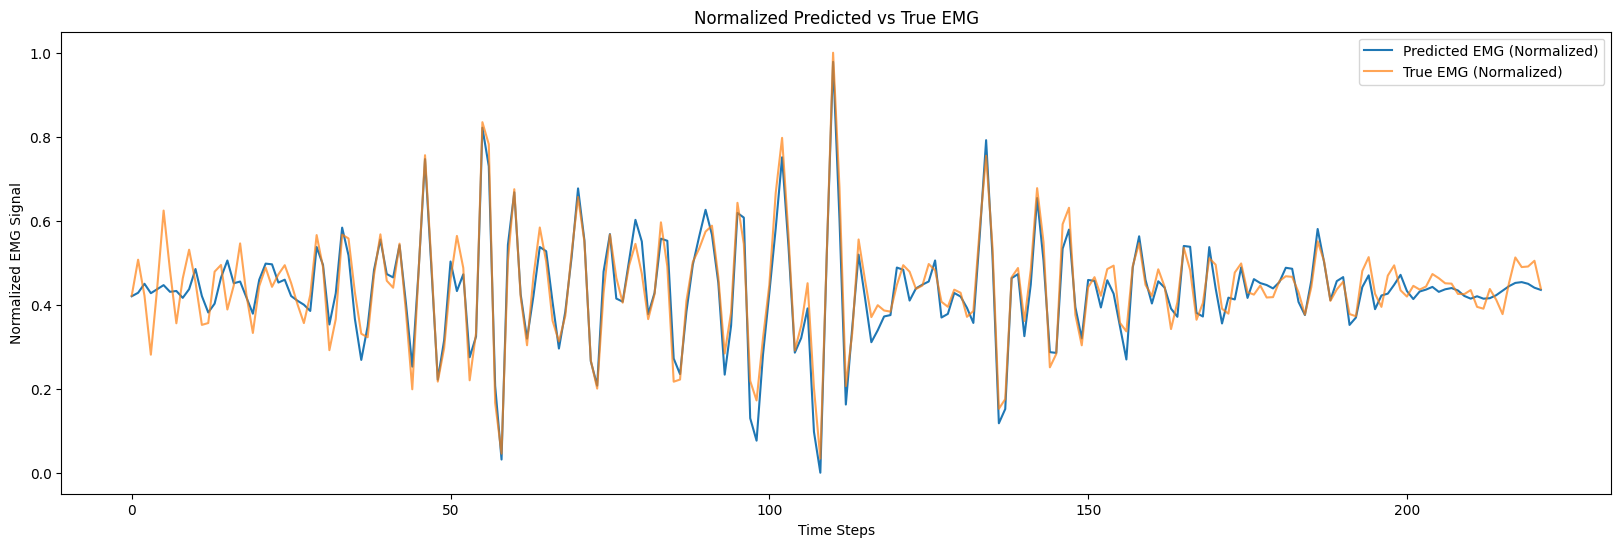

In [11]:
plt.figure(figsize=(20, 6))
plt.plot(pred_emg_norm, label='Predicted EMG (Normalized)')
plt.plot(true_emg_norm, label='True EMG (Normalized)', alpha=0.7)
plt.title('Normalized Predicted vs True EMG')
plt.xlabel('Time Steps')
plt.ylabel('Normalized EMG Signal')
plt.legend()

In [12]:
loss_functions = ['mse', 'mae', 'huber', 'rmse', 'snr', 'psnr', 'cosine', 'pearson', 'spectral', 'stft', 'envelope', 'rms_envelope']

In [13]:
import torch
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import pearsonr
from scipy.signal import hilbert, stft
from scipy.fft import fft
from scipy.spatial.distance import cosine as cosine_distance
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
import pywt
# warnings.filterwarnings('ignore')

# --- Metrics Functions ---
def mse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred)

def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def huber(y_true, y_pred, delta=1.0):
    residual = np.abs(y_true - y_pred)
    return np.where(residual < delta, 0.5 * residual**2, delta * (residual - 0.5 * delta)).mean()

def rmse(y_true, y_pred):
    return np.sqrt(mse(y_true, y_pred))

def snr(y_true, y_pred):
    signal_power = np.mean(y_true**2)
    noise_power = np.mean((y_true - y_pred)**2)
    if noise_power == 0:
        return 100.0  # Very high SNR instead of inf
    return 10 * np.log10(signal_power / noise_power)

def psnr(y_true, y_pred):
    mse_val = mse(y_true, y_pred)
    if mse_val == 0:
        return 100.0  # Very high PSNR instead of inf
    max_val = np.max(y_true)
    return 20 * np.log10(max_val / np.sqrt(mse_val))

def cosine_similarity(y_true, y_pred):
    # Handle edge cases
    if np.allclose(y_true, 0) or np.allclose(y_pred, 0):
        return 0.0
    try:
        return 1 - cosine_distance(y_true, y_pred)
    except:
        return 0.0

def pearson_corr(y_true, y_pred):
    try:
        corr, _ = pearsonr(y_true, y_pred)
        return corr if not np.isnan(corr) else 0.0
    except:
        return 0.0

def spectral_loss(y_true, y_pred):
    try:
        true_fft = np.abs(fft(y_true))
        pred_fft = np.abs(fft(y_pred))
        return np.mean((true_fft - pred_fft)**2)
    except:
        return np.inf

def stft_loss(y_true, y_pred):
    try:
        f_true, t_true, Zxx_true = stft(y_true, nperseg=min(256, len(y_true)//4))
        f_pred, t_pred, Zxx_pred = stft(y_pred, nperseg=min(256, len(y_pred)//4))
        mag_true = np.abs(Zxx_true)
        mag_pred = np.abs(Zxx_pred)
        return np.mean((mag_true - mag_pred)**2)
    except:
        return np.inf

def envelope_loss(y_true, y_pred):
    try:
        env_true = np.abs(hilbert(y_true))
        env_pred = np.abs(hilbert(y_pred))
        return np.mean((env_true - env_pred)**2)
    except:
        return np.inf

def rms_envelope_loss(y_true, y_pred):
    try:
        env_true = np.sqrt(np.mean(y_true**2))
        env_pred = np.sqrt(np.mean(y_pred**2))
        return (env_true - env_pred)**2
    except:
        return np.inf

def dwt_loss(y_true, y_pred, wavelet='db4', levels=4):
    device = y_pred.device
    total_loss = 0
    
    # Convert to numpy for pywt
    pred_np = y_pred.detach().cpu().numpy()
    target_np = y_pred.detach().cpu().numpy()
    
    batch_size = pred_np.shape[0]
    
    for i in range(batch_size):
        # Perform DWT
        pred_coeffs = pywt.wavedec(pred_np[i].flatten(), wavelet, level=levels)
        target_coeffs = pywt.wavedec(target_np[i].flatten(), wavelet, level=levels)
        
        # Compute loss for each level
        for p_coeff, t_coeff in zip(pred_coeffs, target_coeffs):
            p_tensor = torch.tensor(p_coeff, device=device, dtype=torch.float32)
            t_tensor = torch.tensor(t_coeff, device=device, dtype=torch.float32)
            total_loss += F.mse_loss(p_tensor, t_tensor)
    
    return total_loss / batch_size

# --- Main Evaluation Function ---
def evaluate_models(model, imu_segments, emg_segments, loss_functions, model_checkpoint_dir='./model_checkpoint/shubhranil/', device='cpu'):
    """
    Evaluate multiple models trained with different loss functions
    
    Args:
        model: Model architecture (will be loaded with different weights)
        imu_segments: List of IMU data segments
        emg_segments: List of EMG data segments  
        loss_functions: List of loss function names used for training
        model_checkpoint_dir: Directory containing saved models
        device: Device to run inference on
    
    Returns:
        Dictionary containing all results
    """
    
    results = {}
    
    # Check if model files exist
    checkpoint_path = Path(model_checkpoint_dir)
    if not checkpoint_path.exists():
        print(f"Warning: Checkpoint directory {model_checkpoint_dir} does not exist!")
        return results
    
    for loss_fn in loss_functions:
        model_path = checkpoint_path / f'model_best_{loss_fn}.pth'
        
        if not model_path.exists():
            print(f"Warning: Model file {model_path} not found! Skipping {loss_fn}")
            continue
            
        print(f"Evaluating model trained with {loss_fn} loss...")
        
        # Load model
        try:
            model.load_state_dict(torch.load(model_path, map_location=device))
            model.eval()
        except Exception as e:
            print(f"Error loading model {loss_fn}: {e}")
            continue

        # Initialize metrics storage
        metrics_per_sample = {
            'mse': [],
            'mae': [],
            'huber': [],
            'rmse': [],
            'snr': [],
            'psnr': [],
            'cosine': [],
            'pearson': [],
            'spectral': [],
            'stft': [],
            'envelope': [],
            'rms_envelope': [],
            'r2': []
        }

        # Evaluate on all segments
        for idx in range(len(imu_segments)):
            try:
                # Get prediction
                predicted_emg = predict_emg(model, imu_segments[idx], device)
                
                # Prepare data
                true_emg = np.array(emg_segments[idx])
                pred_emg = predicted_emg
                
                # Ensure same length
                min_len = min(len(true_emg), len(pred_emg))
                true_emg = true_emg[:min_len]
                pred_emg = pred_emg[:min_len]
                
                # Normalize data
                scaler = MinMaxScaler()
                combined_data = np.concatenate([true_emg.reshape(-1, 1), pred_emg.reshape(-1, 1)], axis=0)
                scaler.fit(combined_data)
                
                y_true = scaler.transform(true_emg.reshape(-1, 1)).flatten()
                y_pred = scaler.transform(pred_emg.reshape(-1, 1)).flatten()

                # Calculate all metrics
                metrics_per_sample['mse'].append(mse(y_true, y_pred))
                metrics_per_sample['mae'].append(mae(y_true, y_pred))
                metrics_per_sample['huber'].append(huber(y_true, y_pred))
                metrics_per_sample['rmse'].append(rmse(y_true, y_pred))
                metrics_per_sample['snr'].append(snr(y_true, y_pred))
                metrics_per_sample['psnr'].append(psnr(y_true, y_pred))
                metrics_per_sample['cosine'].append(cosine_similarity(y_true, y_pred))
                metrics_per_sample['pearson'].append(pearson_corr(y_true, y_pred))
                metrics_per_sample['spectral'].append(spectral_loss(y_true, y_pred))
                metrics_per_sample['stft'].append(stft_loss(y_true, y_pred))
                metrics_per_sample['envelope'].append(envelope_loss(y_true, y_pred))
                metrics_per_sample['rms_envelope'].append(rms_envelope_loss(y_true, y_pred))
                metrics_per_sample['r2'].append(r2_score(y_true, y_pred))
                
            except Exception as e:
                print(f"Error processing segment {idx} for model {loss_fn}: {e}")
                # Add NaN values for failed samples
                for metric in metrics_per_sample:
                    metrics_per_sample[metric].append(np.nan)

        results[loss_fn] = metrics_per_sample
        print(f"Completed evaluation for {loss_fn} model")

    return results

# --- Table Creation Functions ---
def create_summary_table(results, agg_func, agg_name):
    """Create summary table with aggregated metrics"""
    
    if not results:
        print("No results to display!")
        return pd.DataFrame()
    
    loss_functions = list(results.keys())
    metric_names = [
        'mse', 'mae', 'huber', 'rmse', 'snr', 'psnr', 'cosine', 
        'pearson', 'spectral', 'stft', 'envelope', 'rms_envelope', 'r2'
    ]
    
    table = pd.DataFrame(columns=loss_functions, index=metric_names)

    for loss_fn in loss_functions:
        for metric in metric_names:
            values = results[loss_fn][metric]
            # Remove NaN values for aggregation
            clean_values = [v for v in values if not np.isnan(v) and not np.isinf(v)]
            if clean_values:
                table.loc[metric, loss_fn] = agg_func(clean_values)
            else:
                table.loc[metric, loss_fn] = np.nan
    
    print(f"\n=== {agg_name.upper()} ===")
    print(table.round(4))
    return table

def plot_comparison(results):
    """Create comparison plots"""
    
    if not results:
        print("No results to plot!")
        return
    
    # Select key metrics for plotting
    key_metrics = ['mse', 'mae', 'huber', 'rmse', 'snr', 'psnr', 'cosine', 'pearson', 'spectral', 'stft', 'envelope', 'rms_envelope']

    loss_functions = list(results.keys())
    
    fig, axes = plt.subplots(4, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for i, metric in enumerate(key_metrics):
        ax = axes[i]
        
        # Prepare data for boxplot
        data_to_plot = []
        labels = []
        
        for loss_fn in loss_functions:
            values = results[loss_fn][metric]
            clean_values = [v for v in values if not np.isnan(v) and not np.isinf(v)]
            if clean_values:
                data_to_plot.append(clean_values)
                labels.append(loss_fn)
        
        if data_to_plot:
            ax.boxplot(data_to_plot, labels=labels)
            ax.set_title(f'{metric.upper()} Comparison')
            ax.set_ylabel(metric.upper())
            ax.tick_params(axis='x', rotation=45)
            ax.grid(True, alpha=0.3)
    
    # Remove extra subplot
    fig.delaxes(axes[5])
    
    plt.tight_layout()
    plt.show()

# --- Usage Example ---
def run_evaluation():
    """
    Main function to run the evaluation
    Replace the variables below with your actual data and model
    """
    
    # Replace with your actual loss functions
    loss_functions = ['mse', 'mae', 'huber', 'rmse', 'snr', 'psnr', 'cosine', 'pearson', 'spectral', 'stft', 'envelope', 'rms_envelope']  
    
    # Replace with your actual model checkpoint directory
    model_checkpoint_dir = './model_checkpoint/shubhranil/'
    
    # Replace with your actual device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Run evaluation
    print("Starting model evaluation...")
    results = evaluate_models(
        model=model,  # Your model instance
        imu_segments=imu_segments,  # Your IMU data
        emg_segments=emg_segments,  # Your EMG data
        loss_functions=loss_functions,
        model_checkpoint_dir=model_checkpoint_dir,
        device=device
    )
    
    if results:
        # Create summary tables
        average_table = create_summary_table(results, np.mean, "Average over All Data")
        best_table = create_summary_table(results, np.min, "Best Performance")
        worst_table = create_summary_table(results, np.max, "Worst Performance")
        
        # Create plots
        plot_comparison(results)
        
        # Save results
        average_table.to_csv('average_performance.csv')
        best_table.to_csv('best_performance.csv')
        worst_table.to_csv('worst_performance.csv')
        
        print("\nEvaluation completed!")
        print("Results saved to CSV files.")
        
        return results, average_table, best_table, worst_table
    else:
        print("No valid results obtained!")
        return None

# Uncomment the line below to run the evaluation

Starting model evaluation...
Evaluating model trained with mse loss...
Completed evaluation for mse model
Evaluating model trained with mae loss...
Completed evaluation for mae model
Evaluating model trained with huber loss...
Completed evaluation for huber model
Evaluating model trained with rmse loss...
Completed evaluation for rmse model
Evaluating model trained with snr loss...
Completed evaluation for snr model
Evaluating model trained with psnr loss...
Completed evaluation for psnr model
Evaluating model trained with cosine loss...
Completed evaluation for cosine model
Evaluating model trained with pearson loss...
Completed evaluation for pearson model
Evaluating model trained with spectral loss...
Completed evaluation for spectral model
Evaluating model trained with stft loss...
Completed evaluation for stft model
Evaluating model trained with envelope loss...
Completed evaluation for envelope model
Evaluating model trained with rms_envelope loss...
Completed evaluation for rms_

C:\Users\saanb\AppData\Local\Temp\ipykernel_22844\205673818.py:286: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_to_plot, labels=labels)
C:\Users\saanb\AppData\Local\Temp\ipykernel_22844\205673818.py:286: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_to_plot, labels=labels)
C:\Users\saanb\AppData\Local\Temp\ipykernel_22844\205673818.py:286: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax.boxplot(data_to_plot, labels=labels)
C:\Users\saanb\AppData\Local\Temp\ipykernel_22844\205673818.py:286: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels

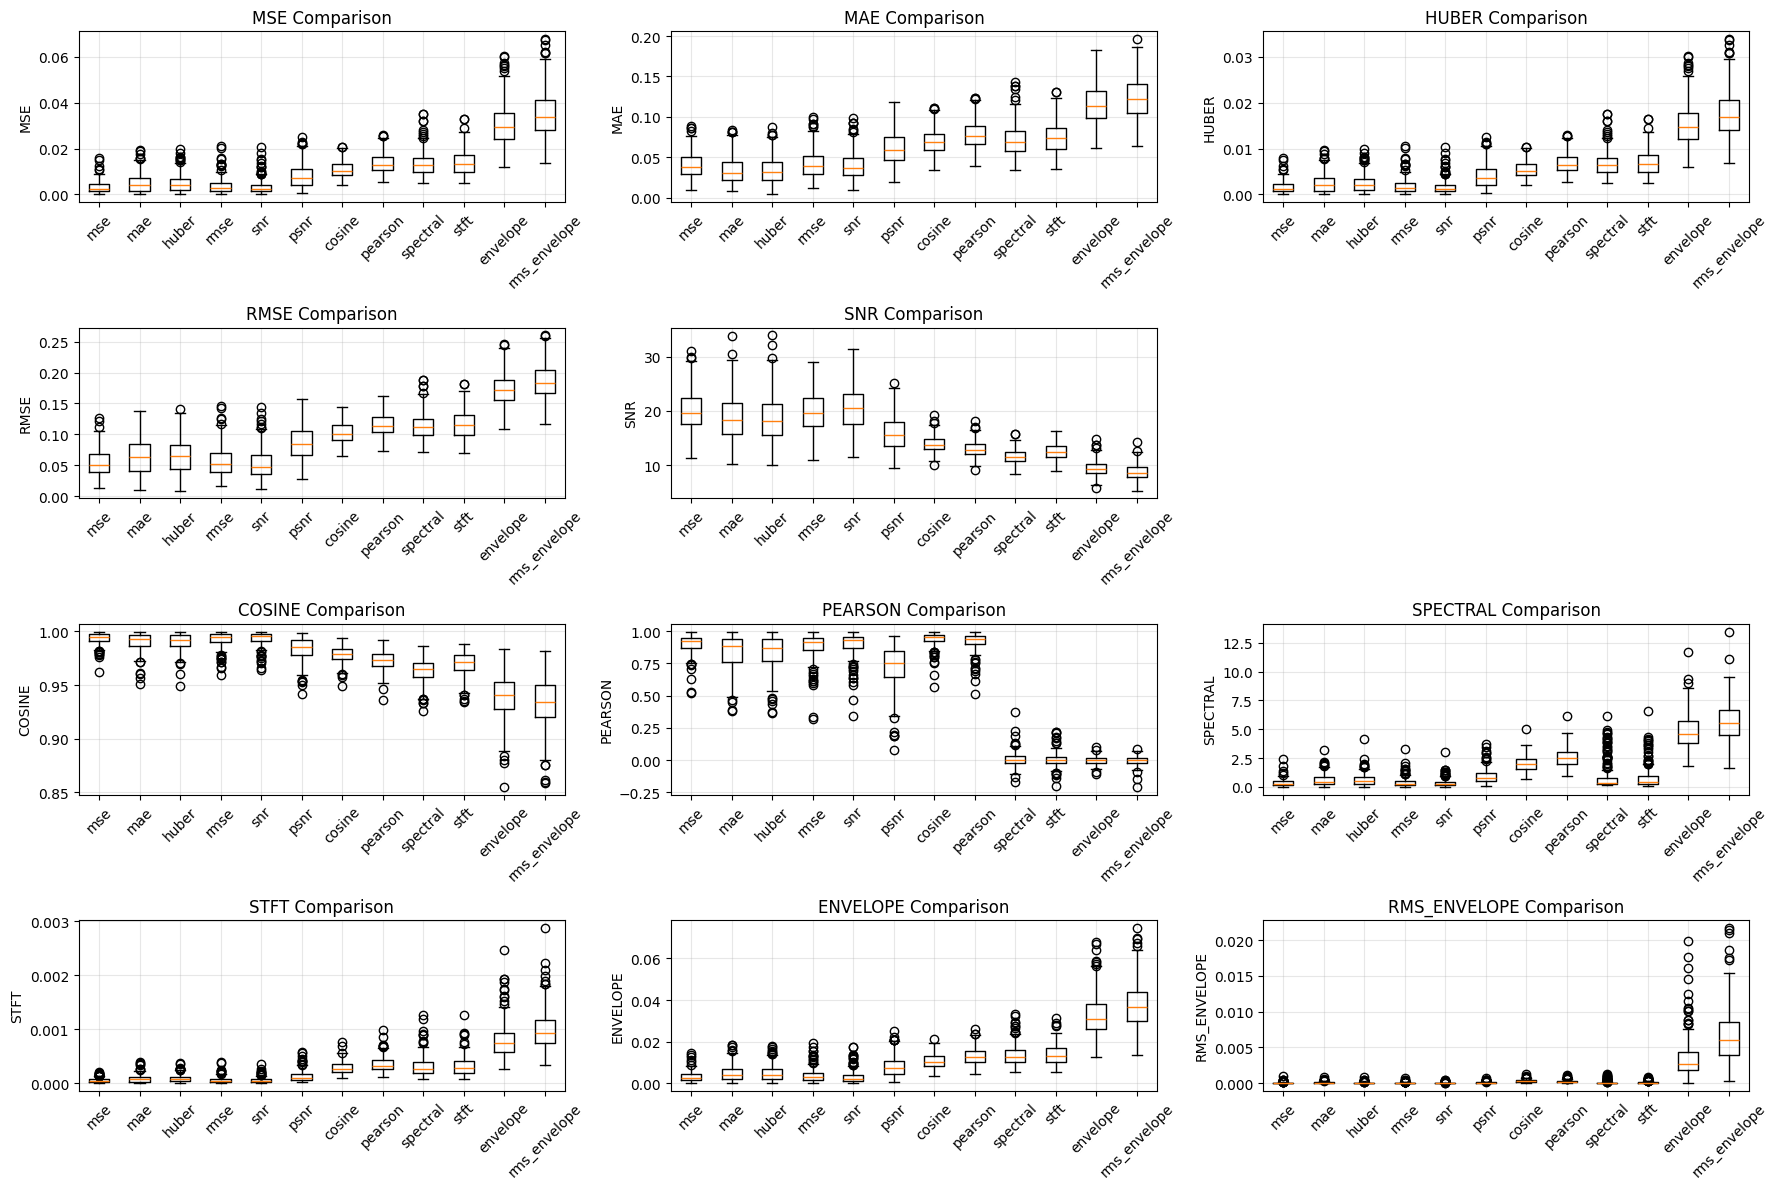


Evaluation completed!
Results saved to CSV files.


In [14]:
results, avg_table, best_table, worst_table = run_evaluation()

In [ ]:
import torch
import numpy as np
import pandas as pd
from pathlib import Path
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings('ignore')

def evaluate_segment_wise_performance(model, imu_segments, emg_segments, loss_functions, 
                                    model_checkpoint_dir='./model_checkpoint/shubhranil/', 
                                    device='cpu', metric='mse'):
    """
    Evaluate models segment-wise and create detailed performance tables
    
    Args:
        model: Model architecture (will be loaded with different weights)
        imu_segments: List of IMU data segments (0 to 174)
        emg_segments: List of EMG data segments (0 to 174)
        loss_functions: List of loss function names used for training
        model_checkpoint_dir: Directory containing saved models
        device: Device to run inference on
        metric: Primary metric to use for evaluation ('mse', 'mae', 'rmse', etc.)
    
    Returns:
        Dictionary containing segment-wise results for each model
    """
    
    # Check if model files exist
    checkpoint_path = Path(model_checkpoint_dir)
    if not checkpoint_path.exists():
        print(f"Warning: Checkpoint directory {model_checkpoint_dir} does not exist!")
        return {}
    
    # Initialize results storage
    all_model_results = {}
    
    # Process each loss function (model)
    for loss_fn in loss_functions:
        model_path = checkpoint_path / f'model_best_{loss_fn}.pth'
        
        if not model_path.exists():
            print(f"Warning: Model file {model_path} not found! Skipping {loss_fn}")
            continue
            
        print(f"Evaluating model trained with {loss_fn} loss...")
        
        # Load model
        try:
            model.load_state_dict(torch.load(model_path, map_location=device))
            model.eval()
        except Exception as e:
            print(f"Error loading model {loss_fn}: {e}")
            continue

        # Initialize segment-wise metrics for this model
        segment_results = {}
        
        # Evaluate on all segments (0 to 174)
        for segment_idx in range(len(imu_segments)):
            try:
                # Get prediction
                predicted_emg = predict_emg(model, imu_segments[segment_idx], device)
                
                # Prepare data
                true_emg = np.array(emg_segments[segment_idx])
                pred_emg = predicted_emg
                
                # Ensure same length
                min_len = min(len(true_emg), len(pred_emg))
                true_emg = true_emg[:min_len]
                pred_emg = pred_emg[:min_len]
                
                # Normalize data
                scaler = MinMaxScaler()
                combined_data = np.concatenate([true_emg.reshape(-1, 1), pred_emg.reshape(-1, 1)], axis=0)
                scaler.fit(combined_data)
                
                y_true = scaler.transform(true_emg.reshape(-1, 1)).flatten()
                y_pred = scaler.transform(pred_emg.reshape(-1, 1)).flatten()

                # Calculate all metrics for this segment
                segment_metrics = {
                    'mse': mse(y_true, y_pred),
                    'mae': mae(y_true, y_pred),
                    'huber': huber(y_true, y_pred),
                    'rmse': rmse(y_true, y_pred),
                    'snr': snr(y_true, y_pred),
                    'psnr': psnr(y_true, y_pred),
                    'cosine': cosine_similarity(y_true, y_pred),
                    'pearson': pearson_corr(y_true, y_pred),
                    'spectral': spectral_loss(y_true, y_pred),
                    'stft': stft_loss(y_true, y_pred),
                    'envelope': envelope_loss(y_true, y_pred),
                    'rms_envelope': rms_envelope_loss(y_true, y_pred),
                    'r2': r2_score(y_true, y_pred)
                }
                
                segment_results[f'Segment_{segment_idx}'] = segment_metrics
                
            except Exception as e:
                print(f"Error processing segment {segment_idx} for model {loss_fn}: {e}")
                # Add NaN values for failed segments
                segment_results[f'Segment_{segment_idx}'] = {
                    'mse': np.nan, 'mae': np.nan, 'huber': np.nan, 'rmse': np.nan,
                    'snr': np.nan, 'psnr': np.nan, 'cosine': np.nan, 'pearson': np.nan,
                    'spectral': np.nan, 'stft': np.nan, 'envelope': np.nan, 
                    'rms_envelope': np.nan, 'r2': np.nan
                }

        all_model_results[loss_fn] = segment_results
        print(f"Completed evaluation for {loss_fn} model")

    return all_model_results

def create_segment_wise_tables(all_model_results, save_dir='./results/'):
    """
    Create and save segment-wise performance tables for each model
    
    Args:
        all_model_results: Dictionary containing results from evaluate_segment_wise_performance
        save_dir: Directory to save the CSV files
    """
    
    if not all_model_results:
        print("No results to process!")
        return
    
    # Create save directory if it doesn't exist
    save_path = Path(save_dir)
    save_path.mkdir(parents=True, exist_ok=True)
    
    # Get all metrics
    metric_names = [
        'mse', 'mae', 'huber', 'rmse', 'snr', 'psnr', 'cosine', 
        'pearson', 'spectral', 'stft', 'envelope', 'rms_envelope', 'r2'
    ]
    
    # Process each model
    for model_name, segment_results in all_model_results.items():
        print(f"Creating table for {model_name} model...")
        
        # Get segment names (columns)
        segment_names = list(segment_results.keys())
        
        # Create DataFrame with metrics as rows and segments as columns
        df = pd.DataFrame(index=metric_names, columns=segment_names)
        
        # Fill the DataFrame
        for segment_name, metrics in segment_results.items():
            for metric_name in metric_names:
                df.loc[metric_name, segment_name] = metrics.get(metric_name, np.nan)
        
        # Convert to numeric and round
        df = df.apply(pd.to_numeric, errors='coerce').round(6)
        
        # Save to CSV
        filename = f"{model_name}_overall_performance.csv"
        filepath = save_path / filename
        df.to_csv(filepath)
        
        print(f"Saved {filename}")
        
        # Display summary statistics
        print(f"\nSummary for {model_name}:")
        print(f"Total segments: {len(segment_names)}")
        print(f"Metrics calculated: {len(metric_names)}")
        print(f"Average MSE: {df.loc['mse'].mean():.6f}")
        print(f"Average MAE: {df.loc['mae'].mean():.6f}")
        print(f"Average RMSE: {df.loc['rmse'].mean():.6f}")
        print("-" * 50)

def create_comparison_heatmap(all_model_results, metric='mse', save_dir='./results/'):
    """
    Create a heatmap comparing all models across segments for a specific metric
    
    Args:
        all_model_results: Dictionary containing results from evaluate_segment_wise_performance
        metric: Metric to visualize ('mse', 'mae', 'rmse', etc.)
        save_dir: Directory to save the plot
    """
    
    import matplotlib.pyplot as plt
    import seaborn as sns
    
    if not all_model_results:
        print("No results to plot!")
        return
    
    # Create comparison DataFrame
    model_names = list(all_model_results.keys())
    
    # Get first model to determine segment count
    first_model = list(all_model_results.values())[0]
    segment_names = list(first_model.keys())
    
    # Create DataFrame for heatmap
    heatmap_data = pd.DataFrame(index=model_names, columns=segment_names)
    
    for model_name, segment_results in all_model_results.items():
        for segment_name, metrics in segment_results.items():
            heatmap_data.loc[model_name, segment_name] = metrics.get(metric, np.nan)
    
    # Convert to numeric
    heatmap_data = heatmap_data.apply(pd.to_numeric, errors='coerce')
    
    # Create heatmap
    plt.figure(figsize=(20, 8))
    sns.heatmap(heatmap_data, annot=False, cmap='viridis', cbar=True)
    plt.title(f'Model Comparison - {metric.upper()} across All Segments')
    plt.xlabel('Segments')
    plt.ylabel('Models (Loss Functions)')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    # Save plot
    save_path = Path(save_dir)
    save_path.mkdir(parents=True, exist_ok=True)
    plt.savefig(save_path / f'model_comparison_{metric}_heatmap.png', dpi=300, bbox_inches='tight')
    plt.show()

def run_segment_wise_evaluation():
    """
    Main function to run the segment-wise evaluation
    Replace the variables below with your actual data and model
    """
    
    # Replace with your actual loss functions
    loss_functions = ['mse', 'mae', 'huber', 'rmse', 'snr', 'psnr', 'cosine', 
                     'pearson', 'spectral', 'stft', 'envelope', 'rms_envelope']
    
    # Replace with your actual model checkpoint directory
    model_checkpoint_dir = './model_checkpoint/shubhranil/'
    
    # Replace with your actual device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    # Replace with your actual save directory
    save_dir = './results/'
    
    # Run segment-wise evaluation
    print("Starting segment-wise model evaluation...")
    print(f"Expected segments: 0 to {len(imu_segments)-1}")
    
    all_results = evaluate_segment_wise_performance(
        model=model,  # Your model instance
        imu_segments=imu_segments,  # Your IMU data (should have 175 segments: 0-174)
        emg_segments=emg_segments,  # Your EMG data (should have 175 segments: 0-174)
        loss_functions=loss_functions,
        model_checkpoint_dir=model_checkpoint_dir,
        device=device
    )
    
    if all_results:
        # Create and save segment-wise tables
        create_segment_wise_tables(all_results, save_dir)
        
        # Create comparison heatmap for key metrics
        create_comparison_heatmap(all_results, metric='mse', save_dir=save_dir)
        create_comparison_heatmap(all_results, metric='mae', save_dir=save_dir)
        create_comparison_heatmap(all_results, metric='rmse', save_dir=save_dir)
        
        print(f"\nSegment-wise evaluation completed!")
        print(f"Individual model performance tables saved in {save_dir}")
        print(f"File format: {{model_name}}_overall_performance.csv")
        print(f"Heatmap comparisons saved as PNG files")
        
        return all_results
    else:
        print("No valid results obtained!")
        return None

def get_best_worst_segments(all_model_results, metric='mse', save_dir='./results/'):
    """
    Identify best and worst performing segments for each model
    
    Args:
        all_model_results: Dictionary containing results from evaluate_segment_wise_performance
        metric: Metric to analyze ('mse', 'mae', 'rmse', etc.)
        save_dir: Directory to save the analysis
    """
    
    if not all_model_results:
        print("No results to analyze!")
        return
    
    analysis_results = {}
    
    for model_name, segment_results in all_model_results.items():
        # Extract metric values for all segments
        metric_values = {}
        for segment_name, metrics in segment_results.items():
            value = metrics.get(metric, np.nan)
            if not np.isnan(value) and not np.isinf(value):
                metric_values[segment_name] = value
        
        if not metric_values:
            continue
        
        # For error metrics (lower is better)
        if metric in ['mse', 'mae', 'huber', 'rmse', 'spectral', 'stft', 'envelope', 'rms_envelope']:
            best_segment = min(metric_values, key=metric_values.get)
            worst_segment = max(metric_values, key=metric_values.get)
        # For performance metrics (higher is better)
        else:
            best_segment = max(metric_values, key=metric_values.get)
            worst_segment = min(metric_values, key=metric_values.get)
        
        analysis_results[model_name] = {
            'best_segment': best_segment,
            'best_value': metric_values[best_segment],
            'worst_segment': worst_segment,
            'worst_value': metric_values[worst_segment],
            'avg_value': np.mean(list(metric_values.values())),
            'std_value': np.std(list(metric_values.values()))
        }
    
    # Create summary DataFrame
    analysis_df = pd.DataFrame(analysis_results).T
    
    # Save analysis
    save_path = Path(save_dir)
    save_path.mkdir(parents=True, exist_ok=True)
    analysis_df.to_csv(save_path / f'best_worst_segments_{metric}.csv')
    
    print(f"\nBest/Worst Segment Analysis for {metric.upper()}:")
    print(analysis_df.round(6))
    
    return analysis_results


Starting segment-wise model evaluation...
Expected segments: 0 to 174
Evaluating model trained with mse loss...
Completed evaluation for mse model
Evaluating model trained with mae loss...
Completed evaluation for mae model
Evaluating model trained with huber loss...
Completed evaluation for huber model
Evaluating model trained with rmse loss...
Completed evaluation for rmse model
Evaluating model trained with snr loss...
Completed evaluation for snr model
Evaluating model trained with psnr loss...
Completed evaluation for psnr model
Evaluating model trained with cosine loss...
Completed evaluation for cosine model
Evaluating model trained with pearson loss...
Completed evaluation for pearson model
Evaluating model trained with spectral loss...
Completed evaluation for spectral model
Evaluating model trained with stft loss...
Completed evaluation for stft model
Evaluating model trained with envelope loss...
Completed evaluation for envelope model
Evaluating model trained with rms_envel

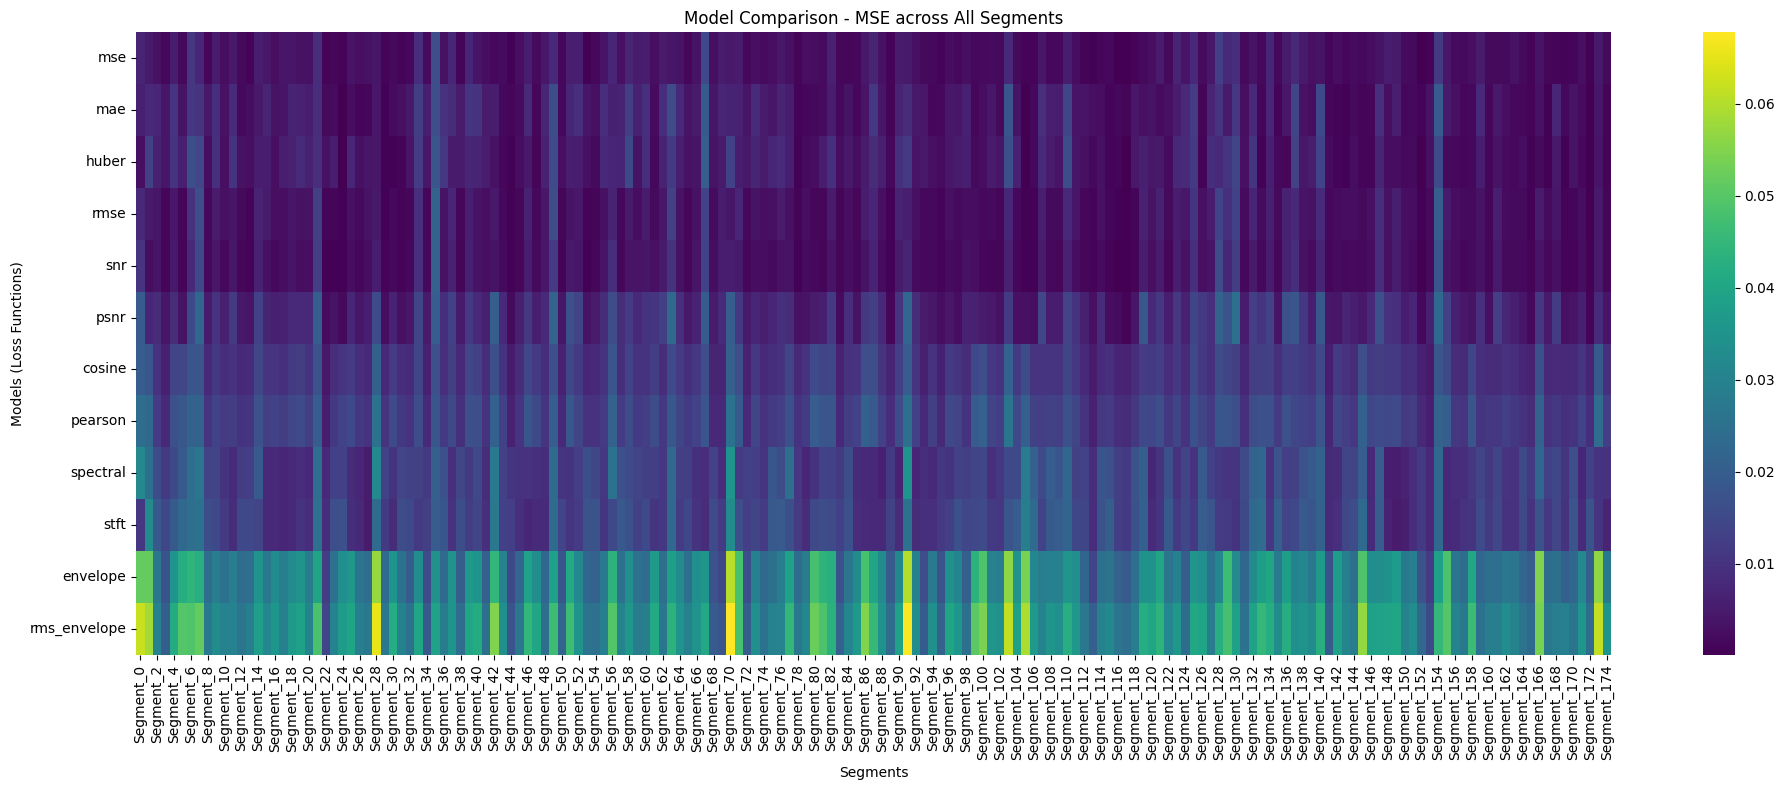

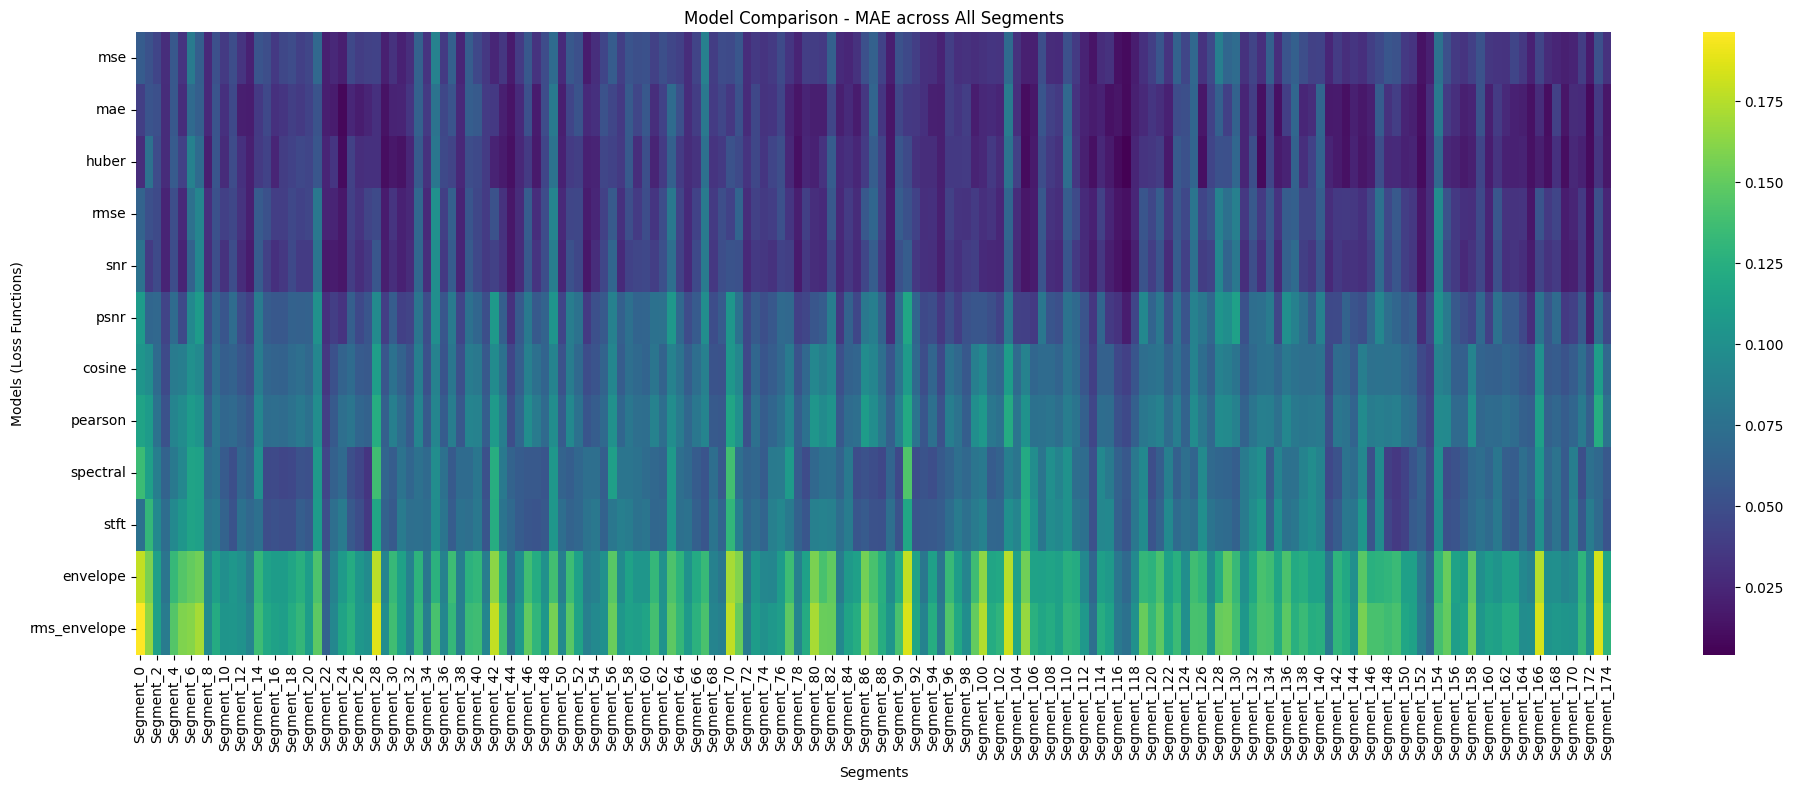

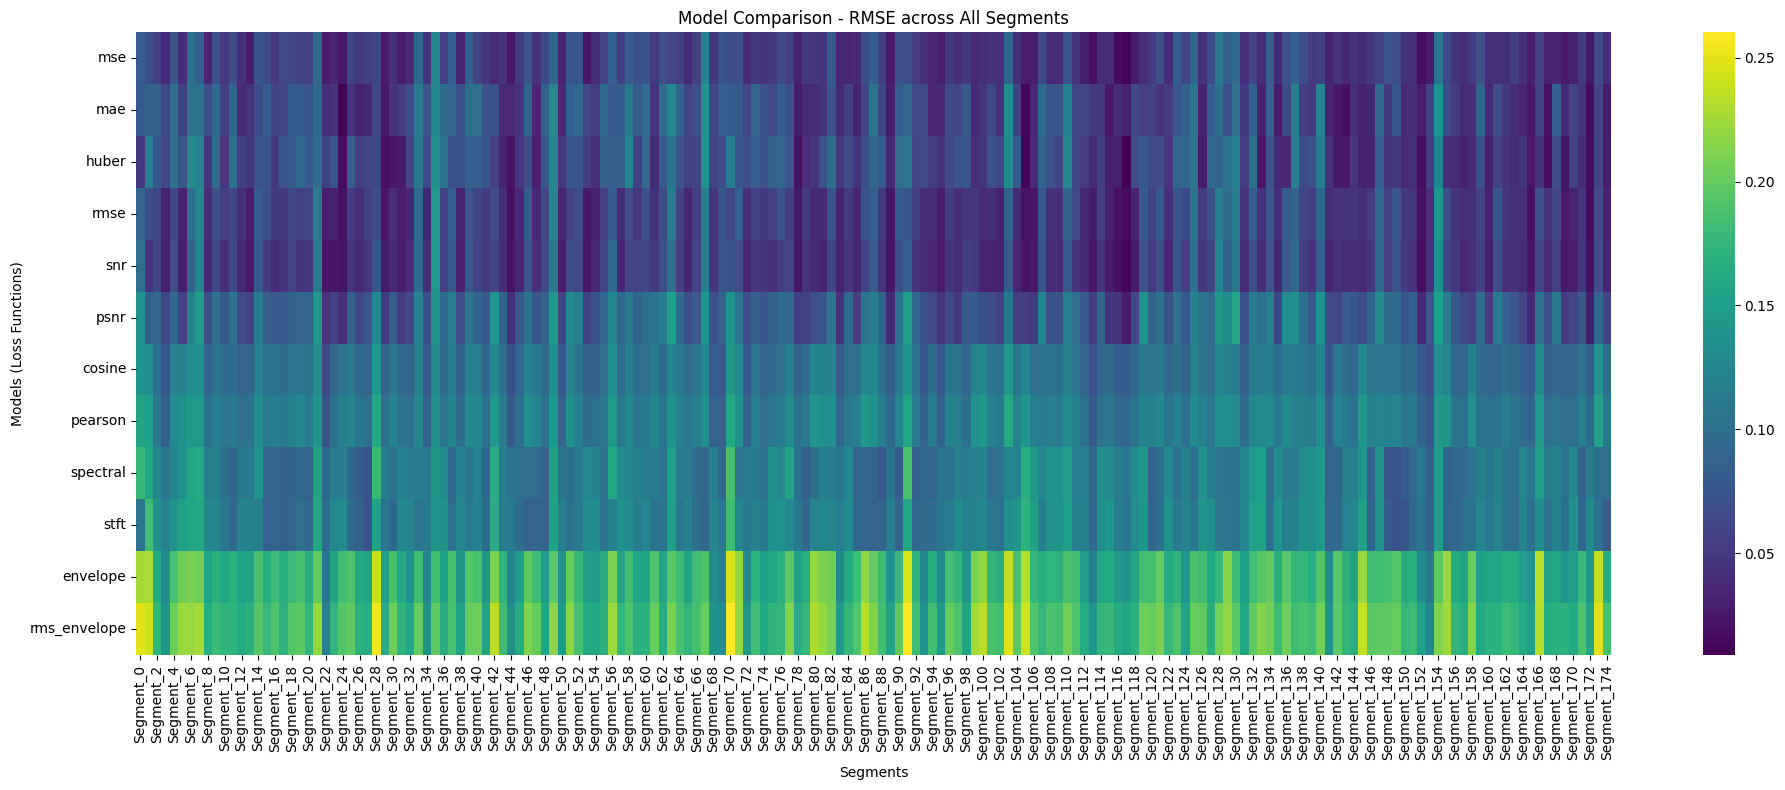


Segment-wise evaluation completed!
Individual model performance tables saved in ./results/
File format: {model_name}_overall_performance.csv
Heatmap comparisons saved as PNG files


{'mse': {'Segment_0': {'mse': 0.006759531487370645,
   'mae': 0.05923023428450063,
   'huber': np.float64(0.0033797657436853224),
   'rmse': np.float64(0.08221636994766093),
   'snr': np.float64(15.909572339544066),
   'psnr': np.float64(21.700834045762562),
   'cosine': np.float64(0.9871049467309736),
   'pearson': np.float64(0.8859572700442613),
   'spectral': np.float64(0.47009130828226164),
   'stft': np.float64(8.285469319408822e-05),
   'envelope': np.float64(0.006849108511697438),
   'rms_envelope': np.float64(8.301863722681957e-05),
   'r2': 0.7834895538346844},
  'Segment_1': {'mse': 0.004576082182751222,
   'mae': 0.052298597220385094,
   'huber': np.float64(0.002288041091375611),
   'rmse': np.float64(0.0676467455444179),
   'snr': np.float64(17.366548516474836),
   'psnr': np.float64(23.199262173339005),
   'cosine': np.float64(0.9908716563306076),
   'pearson': np.float64(0.9154874037682491),
   'spectral': np.float64(0.5226631334067692),
   'stft': np.float64(6.9710922390

In [26]:
run_segment_wise_evaluation()